In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalMaxPooling2D
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import MaxPool2D
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input,decode_predictions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
print(tf.__version__)


2.1.0


# Load the Data

In [2]:
cifar10 = tf.keras.datasets.cifar10

In [3]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

In [4]:
x_train, x_test = x_train/255.0, x_test/255.0 


In [5]:
y_train, y_test = y_train.flatten(), y_test.flatten()

# Number of Classes

In [6]:
k = len(set(y_train))

In [7]:
pd.unique(y_train)

array([6, 9, 4, 1, 2, 7, 8, 3, 5, 0], dtype=uint8)

In [8]:
x_train[0].shape

(32, 32, 3)

# Labels

In [9]:
labels = ["Aeroplane",
         "Automobile",
         "Bird",
         "Cat",
         "Deer",
         "Dog",
         "Frog",
         "Horse",
         "Ship",
         "Truck"]

# Building the Model

In [10]:
def get_regularized_model(wd,dropout_rate):
    Model = Sequential([
        Conv2D(16,(3,3),kernel_regularizer=regularizers.l2(wd), activation = "relu", input_shape = (32, 32, 3)),
        MaxPooling2D((3,3)),
        BatchNormalization(momentum=0.95, epsilon=0.005,axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(dropout_rate),
        Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(wd), activation='relu'),
        MaxPooling2D((2,2)),
        BatchNormalization(momentum=0.95, epsilon=0.005,axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation = "relu"),
        BatchNormalization(momentum=0.95, epsilon=0.005,axis = -1,
                           beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
                           gamma_initializer=tf.keras.initializers.Constant(value=0.9)),
        Dropout(dropout_rate),
        Dense(10, activation = "softmax")
                           ])
    return Model



# Hyperparameters

In [11]:

regularized_model = get_regularized_model(1e-8, 0.2)

# Model CheckPoint

In [12]:
checkpoint_path = "Model_CheckPoints"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,save_freq="epoch", verbose = 1)
                            

In [16]:
opt = tf.keras.optimizers.Adam() # learning_rate=0.005
acc = tf.keras.metrics.SparseCategoricalAccuracy()
mae = tf.keras.metrics.MeanAbsoluteError()
regularized_model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) 
reg_history = regularized_model.fit(x_train,
                                   y_train,
                                   epochs = 15,
                                   validation_split = 0.15,
                                   batch_size = 64,
                                    verbose = 2,
                                   callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)])

Train on 42500 samples, validate on 7500 samples
Epoch 1/15
42500/42500 - 10s - loss: 0.8446 - accuracy: 0.7029 - val_loss: 0.9112 - val_accuracy: 0.6837
Epoch 2/15
42500/42500 - 9s - loss: 0.8315 - accuracy: 0.7095 - val_loss: 0.9768 - val_accuracy: 0.6689
Epoch 3/15
42500/42500 - 9s - loss: 0.8257 - accuracy: 0.7089 - val_loss: 0.7695 - val_accuracy: 0.7315
Epoch 4/15
42500/42500 - 9s - loss: 0.8079 - accuracy: 0.7147 - val_loss: 0.8136 - val_accuracy: 0.7097
Epoch 5/15
42500/42500 - 9s - loss: 0.8114 - accuracy: 0.7121 - val_loss: 0.7804 - val_accuracy: 0.7296
Epoch 6/15
42500/42500 - 9s - loss: 0.8000 - accuracy: 0.7191 - val_loss: 0.8033 - val_accuracy: 0.7155
Epoch 7/15
42500/42500 - 9s - loss: 0.7968 - accuracy: 0.7173 - val_loss: 0.7775 - val_accuracy: 0.7309
Epoch 8/15
42500/42500 - 9s - loss: 0.7907 - accuracy: 0.7211 - val_loss: 0.8076 - val_accuracy: 0.7180


# Prediction

[[2.3217715e-02 6.8207544e-01 2.6052212e-04 1.7896129e-02 8.1353246e-05
  2.2902358e-03 1.1104125e-03 5.9517747e-04 2.6476109e-01 7.7119074e-03]]


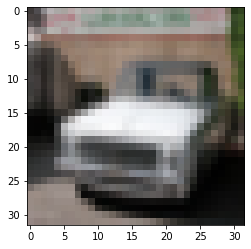

label:Automobile


In [14]:
random_index = np.random.choice(x_test.shape[0])
test_image = x_test[random_index]
print(regularized_model.predict(test_image[np.newaxis,...,]))
plt.imshow(test_image)
plt.show()
print(f"label:{labels[y_test[random_index]]}")

# Plot

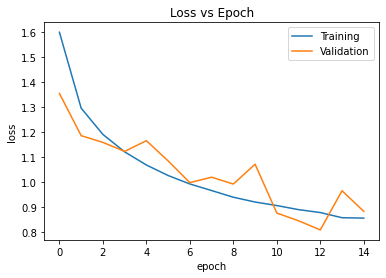

In [15]:
plt.plot(reg_history.history["loss"])
plt.plot(reg_history.history["val_loss"])
plt.title("Loss vs Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Training", "Validation"], loc = "upper right")
plt.show()